# Model Training: Forwards - Linear Regression

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures


In [3]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. TOTAL POINTS - although we may want to split this up into TOTAL ASSISTS and GOALS instead
3. TOTAL ASSISTS - although we may want to split this up into FIRST ASSISTS and SECOND ASSISTS instead
4. XGF/60 - This may not make sense to use, since it is so closely tied to XGA, which is part of the intersection
5. ON THE FLY STARTS/60 - This is probably covered by TOI/GP which it has a -.75 correlation with
6. OFF. ZONE FACEOFFS/60 - May make sense to be integrated into the PCA as it is a bit of a nuanced statistic
7. TOTAL POINTS/60 - Is too closely linked to TOTAL POINTS. We should use one or the other.
8. SHOTS - I think this would be a good metric to try to include.
9. GOALS - I think it goes without saying that we should use Goals.
10. We may want to include 'LDGF', 'OFF. ZONE STARTS', 'LDCF', 'MDGF', 'OFF. ZONE FACEOFFS',
       'HDCF', 'CF', 'FF', 'SF', 'MDCF', 'SCF', 'XGF', 'ICF', 'HDGF', 'IFF',
       'ISCF', 'IXG', 'GF' as a PCA

In [4]:
# # THE FOLLOWING CELL UTILIZES MANUAL FEATURE SELECTION

# forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# # Select only forwards with 41 or more games played
# test_train_data = forwards[(forwards['GP'] >= 41)].copy()

# # Select the features we want to use as predictors
# # numerical_features = ['GOALS/60', 'TOTAL ASSISTS/60', 'FIRST ASSISTS/60', 'SHOTS/60', 'IXG/60', 'ISCF/60', 'IHDCF/60', 'RUSH ATTEMPTS/60', 'REBOUNDS CREATED/60', 'PIM/60', 'TOTAL PENALTIES/60', 'MISCONDUCT/60', 'PENALTIES DRAWN/60', 'GIVEAWAYS/60', 'TAKEAWAYS/60', 'HITS/60', 'HITS TAKEN/60', 'SHOTS BLOCKED/60', 'FACEOFFS WON/60', 'FACEOFFS LOST/60', 'CF/60', 'FF/60', 'SF/60', 'GF/60', 'GA/60', 'XGF/60', 'HDCF/60', 'HDCA/60', 'HDGA/60', 'MDGF/60', 'MDGA/60', 'LDCF/60', 'LDCA/60', 'LDGF/60', 'LDGA/60', 'OFF.\xa0ZONE STARTS/60', 'NEU.\xa0ZONE FACEOFFS/60', 'DEF.\xa0ZONE FACEOFFS/60', 'ON\xa0THE\xa0FLY STARTS', 'TOTAL ASSISTS/GP', 'FIRST ASSISTS/GP', 'SECOND ASSISTS/GP', 'TOTAL POINTS/GP', 'SHOTS/GP', 'IXG/GP', 'ISCF/GP', 'IHDCF/GP', 'REBOUNDS CREATED/GP', 'PIM/GP', 'MINOR/GP', 'MISCONDUCT/GP', 'PENALTIES DRAWN/GP', 'GIVEAWAYS/GP', 'HITS/GP', 'HITS TAKEN/GP', 'SHOTS BLOCKED/GP', 'FACEOFFS WON/GP', 'FACEOFFS LOST/GP', 'CA/GP', 'FA/GP', 'SA/GP', 'GF/GP', 'GA/GP', 'XGF/GP', 'XGA/GP', 'HDCF/GP', 'HDGA/GP', 'MDGF/GP', 'MDGA/GP', 'LDGF/GP', 'LDGA/GP', 'OFF.\xa0ZONE FACEOFFS/GP']

# selected_features = ['GOALS/GP', 'TOTAL ASSISTS/GP', 'TOTAL POINTS/GP'] + ['GOALS/60', 'TOTAL ASSISTS/60', 'TOTAL POINTS/60']

# # Define transformers
# numerical_transformer = Pipeline(steps = [
#     ('poly', PolynomialFeatures(degree=1)),
#     ('scaler', StandardScaler())
# ])

# preprocessor = ColumnTransformer(transformers=[
#     ('num', numerical_transformer, selected_features)
# ])

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', LinearRegression())
# ])

# X = test_train_data.drop('SALARY CAP PERCENTAGE', axis=1)
# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

In [5]:
# THE FOLLOWING CELL UTILIZES SEQUENTIAL FEATURE SELECTION USING SequentialFeatureSelector from sklearn.feature_selection

forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 60 or more games played
test_train_data = forwards[(forwards['GP'] >= 41)]

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

# Define transformers for the numerical features
transformers = [
    ('num', StandardScaler(), numerical_features)
]

preprocessor = ColumnTransformer(transformers=transformers)

# Define a linear regression model
linear_regression_model = LinearRegression()

# Define the Sequential Feature Selector with the Linear Regression model
sfs = SequentialFeatureSelector(linear_regression_model, n_features_to_select='auto', direction='forward', scoring='neg_mean_squared_error')

# Create a pipeline that includes the preprocessor, SFS, and the regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('sfs', sfs),
    ('regressor', linear_regression_model)
])

# Split your data
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Assuming your pipeline is named 'pipeline' and has been fitted
sfs = pipeline.named_steps['sfs']  # Access the fitted SFS object from the pipeline

# Get the boolean mask of selected features
selected_features_mask = sfs.get_support()

# Apply this mask to the feature names to get the list of selected features
selected_features = numerical_features[selected_features_mask]

print("Selected features:", list(selected_features))


Mean Squared Error: 0.00048343715308463045
Selected features: ['TOI/GP', 'TOTAL ASSISTS/GP', 'SECOND ASSISTS/GP', 'TOTAL POINTS/GP', 'SHOTS/GP', 'IXG/GP', 'ICF/GP', 'ISCF/GP', 'IHDCF/GP', 'REBOUNDS CREATED/GP', 'TOTAL PENALTIES/GP', 'PENALTIES DRAWN/GP', 'GIVEAWAYS/GP', 'HITS TAKEN/GP', 'SHOTS BLOCKED/GP', 'FACEOFFS WON/GP', 'FACEOFFS LOST/GP', 'GOALS/60', 'TOTAL ASSISTS/60', 'FIRST ASSISTS/60', 'SHOTS/60', 'IXG/60', 'ICF/60', 'ISCF/60', 'IHDCF/60', 'REBOUNDS CREATED/60', 'PIM/60', 'TOTAL PENALTIES/60', 'MINOR/60', 'MAJOR/60', 'PENALTIES DRAWN/60', 'GIVEAWAYS/60', 'TAKEAWAYS/60', 'HITS TAKEN/60', 'SHOTS BLOCKED/60', 'FACEOFFS WON/60', 'FACEOFFS LOST/60', 'SF/GP', 'GF/GP', 'XGF/GP', 'XGA/GP', 'HDCF/GP', 'LDGF/GP', 'LDGA/GP', 'OFF.\xa0ZONE STARTS/GP', 'DEF.\xa0ZONE STARTS/GP', 'OFF.\xa0ZONE FACEOFFS/GP', 'CA/60', 'SF/60', 'SA/60', 'GF/60', 'XGF/60', 'HDGA/60', 'LDGA/60', 'OFF.\xa0ZONE STARTS/60', 'OFF.\xa0ZONE FACEOFFS/60', 'DEF.\xa0ZONE FACEOFFS/60']


In [6]:
coefficients = pipeline.named_steps['regressor'].coef_
coefficient_names = list(selected_features)

used_features = []

for name, coef in zip(coefficient_names, coefficients):
    print(f'{name}: {coef}')
    used_features.append(name)

TOI/GP: 0.014031199167033173
TOTAL ASSISTS/GP: 0.012727282106897893
SECOND ASSISTS/GP: -0.0057369257222133095
TOTAL POINTS/GP: 0.02195259451361496
SHOTS/GP: 0.004186123125097876
IXG/GP: 0.0003573796499834655
ICF/GP: 0.027085889025902907
ISCF/GP: -0.018474039896453194
IHDCF/GP: 0.00963384261275033
REBOUNDS CREATED/GP: -0.0017572223098652725
TOTAL PENALTIES/GP: 0.008015899485015071
PENALTIES DRAWN/GP: -0.00973503225695093
GIVEAWAYS/GP: 0.005916528499280253
HITS TAKEN/GP: -0.005105539906382457
SHOTS BLOCKED/GP: -0.0048547012428804305
FACEOFFS WON/GP: 0.03890405570464345
FACEOFFS LOST/GP: -0.030926905977705494
GOALS/60: -0.00840524032504905
TOTAL ASSISTS/60: -0.006188654002888953
FIRST ASSISTS/60: -0.006736895684728338
SHOTS/60: -0.0008664475582854064
IXG/60: -0.0021824709454009994
ICF/60: -0.015786530895541735
ISCF/60: 0.008722127958492386
IHDCF/60: -0.002518531485027691
REBOUNDS CREATED/60: 0.0016480995596662058
PIM/60: 0.013361497093563856
TOTAL PENALTIES/60: -0.03999805814033607
MINOR/

In [7]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [8]:
# Create a feature column for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [9]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards[forwards['GP'] > 21].sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(10)
display_features = ['PLAYER', 'SEASON'] + used_features + ['AAV', 'PRED_AAV', 'DIFF', 'SALARY CAP PERCENTAGE', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,TOI/GP,TOTAL ASSISTS/GP,SECOND ASSISTS/GP,TOTAL POINTS/GP,SHOTS/GP,IXG/GP,ICF/GP,ISCF/GP,...,HDGA/60,LDGA/60,OFF. ZONE STARTS/60,OFF. ZONE FACEOFFS/60,DEF. ZONE FACEOFFS/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
424,alex ovechkin,2008-09,23.004641,0.6835,0.2785,1.3924,6.6835,0.6582,13.0000,6.3418,...,1.49,0.52,10.20,26.51,11.29,"$9,538,462.00","$8,760,819.00","$-777,643.00",0.168227,0.154512
11935,nikita kucherov,2023-24,21.726471,1.1912,0.4853,1.7941,3.9118,0.4118,8.0735,3.3824,...,1.67,0.88,13.28,27.70,10.15,"$9,500,000.00","$12,606,772.00","$3,106,772.00",0.113772,0.150979
3071,ilya kovalchuk,2012-13,24.737387,0.5405,0.2432,0.8378,3.3243,0.2703,6.4324,2.4865,...,1.31,0.38,12.32,25.83,15.27,"$6,666,666.00","$8,952,881.00","$2,286,215.00",0.111111,0.149215
11910,nathan mackinnon,2023-24,22.877295,1.0870,0.5217,1.6957,4.8261,0.4348,8.4783,4.1594,...,1.29,0.71,16.84,35.92,13.53,"$12,600,000.00","$12,324,032.00","$-275,968.00",0.150898,0.147593
9410,leon draisaitl,2020-21,22.188393,0.9464,0.4107,1.5000,3.0000,0.3750,5.3929,3.0536,...,1.26,0.28,11.49,27.09,16.71,"$8,500,000.00","$11,585,911.00","$3,085,911.00",0.104294,0.142158
952,alex ovechkin,2009-10,21.797454,0.8194,0.3056,1.5139,5.1111,0.5139,11.4167,5.0556,...,0.92,0.50,10.09,26.00,11.09,"$9,538,462.00","$7,853,764.00","$-1,684,698.00",0.167931,0.138271
12055,sidney crosby,2023-24,19.981863,0.5294,0.2059,1.0147,3.5147,0.4853,6.0294,3.5735,...,1.90,0.32,16.65,35.46,14.09,"$8,700,000.00","$11,526,889.00","$2,826,889.00",0.104192,0.138047
11810,leon draisaitl,2023-24,20.809204,0.8209,0.3433,1.3433,2.8060,0.3582,5.3731,3.0149,...,1.33,0.50,14.33,29.22,19.71,"$8,500,000.00","$11,246,538.00","$2,746,538.00",0.101796,0.134689
1454,sidney crosby,2009-10,21.954527,0.7160,0.2716,1.3457,3.6790,0.3827,6.1481,3.7654,...,1.48,0.83,14.04,28.31,14.98,"$8,700,000.00","$7,628,028.00","$-1,071,972.00",0.153169,0.134296
11896,mikko rantanen,2023-24,23.166184,0.8116,0.3333,1.3478,3.3913,0.3913,6.6087,3.8406,...,1.28,0.81,17.15,35.47,13.63,"$9,250,000.00","$11,142,252.00","$1,892,252.00",0.110778,0.133440


In [10]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,TOI/GP,TOTAL ASSISTS/GP,SECOND ASSISTS/GP,TOTAL POINTS/GP,SHOTS/GP,IXG/GP,ICF/GP,ISCF/GP,...,HDGA/60,LDGA/60,OFF. ZONE STARTS/60,OFF. ZONE FACEOFFS/60,DEF. ZONE FACEOFFS/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
5276,connor mcdavid,2015-16,18.884815,0.7111,0.3556,1.0667,2.3333,0.2889,3.4667,2.9333,...,1.77,0.82,11.72,25.28,16.38,"$3,775,000.00","$3,686,674.00","$-88,326.00",0.012955,0.051634
6071,connor mcdavid,2016-17,21.131098,0.8537,0.3171,1.2195,3.0732,0.3537,5.1341,3.6707,...,1.39,0.45,12.95,24.45,14.51,"$3,775,000.00","$5,135,948.00","$1,360,948.00",0.012671,0.070355
6841,connor mcdavid,2017-18,21.546341,0.8171,0.3415,1.3171,3.3537,0.4024,5.2927,4.0122,...,1.60,0.93,12.53,25.33,16.13,"$3,775,000.00","$5,432,462.00","$1,657,462.00",0.012333,0.072433
7617,connor mcdavid,2018-19,22.837179,0.9615,0.2308,1.4872,3.0769,0.4103,5.4231,3.7821,...,1.92,0.88,13.71,26.34,15.12,"$12,500,000.00","$8,035,929.00","$-4,464,071.00",0.157233,0.101081
8398,connor mcdavid,2019-20,21.865625,0.9844,0.3906,1.5156,3.3125,0.3594,5.2969,3.5781,...,1.67,0.68,12.95,27.87,12.09,"$12,500,000.00","$9,695,915.00","$-2,804,085.00",0.153374,0.118968
9143,connor mcdavid,2020-21,22.153571,1.2857,0.3929,1.8750,3.5714,0.4107,5.6071,3.9464,...,1.26,0.63,11.99,29.74,11.61,"$12,500,000.00","$10,451,068.00","$-2,048,932.00",0.153374,0.128234
9952,connor mcdavid,2021-22,22.066250,0.9875,0.3750,1.5375,3.9375,0.5125,6.0125,4.2250,...,1.12,0.69,11.08,26.51,13.56,"$12,500,000.00","$9,613,365.00","$-2,886,635.00",0.153374,0.117955
10786,connor mcdavid,2022-23,22.385569,1.0854,0.3537,1.8659,4.2927,0.5366,6.4512,4.6220,...,1.63,0.66,12.36,27.46,16.77,"$12,500,000.00","$10,590,699.00","$-1,909,301.00",0.151515,0.128372
11570,connor mcdavid,2023-24,21.573333,1.3231,0.4923,1.7231,3.4154,0.4462,6.0769,3.8308,...,1.41,0.49,13.35,30.12,14.25,"$12,500,000.00","$10,967,965.00","$-1,532,035.00",0.149701,0.131353


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Centers')

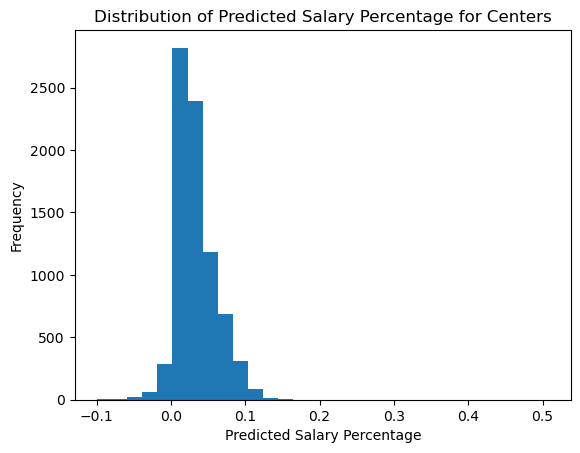

In [11]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards[forwards['PRED_SALARY_PERCENTAGE'] > -0.1]['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Centers')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Forwards')

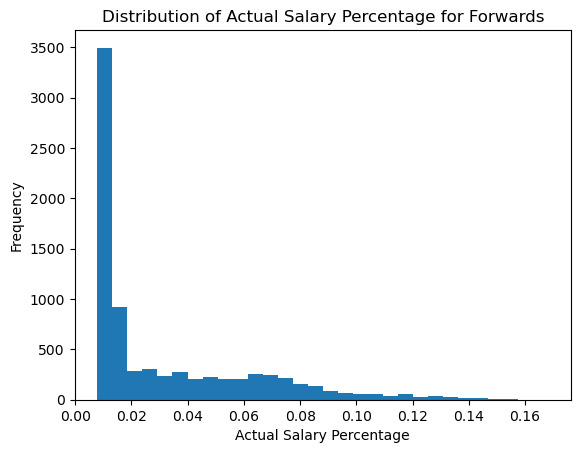

In [12]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Forwards')

In [13]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,TOI/GP,TOTAL ASSISTS/GP,SECOND ASSISTS/GP,TOTAL POINTS/GP,SHOTS/GP,IXG/GP,ICF/GP,...,LDGA/60,OFF. ZONE STARTS/60,OFF. ZONE FACEOFFS/60,DEF. ZONE FACEOFFS/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,Differential
11975,chi,philipp kurashev,2023-24,19.044709,0.4762,0.1270,0.6984,1.7778,0.2063,3.8889,...,1.01,14.35,29.45,14.10,"$2,250,000.00","$6,437,563.00","$4,187,563.00",0.026946,0.077097,4187563.0
11754,col,jonathan drouin,2023-24,17.487121,0.4394,0.2121,0.6212,1.5000,0.1970,2.9697,...,0.60,15.60,29.16,12.63,"$825,000.00","$4,856,345.00","$4,031,345.00",0.009880,0.058160,4031345.0
12045,"mtl, wpg",sean monahan,2023-24,18.082381,0.4143,0.1714,0.7143,2.0571,0.3000,3.5286,...,0.75,13.51,25.31,22.99,"$2,000,000.00","$5,788,561.00","$3,788,561.00",0.023772,0.069324,3788561.0
12119,nyr,vincent trocheck,2023-24,21.314286,0.6000,0.1857,0.9429,2.6571,0.4000,5.4857,...,0.41,12.67,26.30,18.86,"$5,625,000.00","$9,330,330.00","$3,705,330.00",0.067365,0.111740,3705330.0
12133,dal,wyatt johnston,2023-24,16.981905,0.3857,0.0714,0.7571,2.5714,0.3571,4.8714,...,0.87,10.45,19.84,19.63,"$1,000,417.00","$4,631,303.00","$3,630,886.00",0.010709,0.055465,3630886.0
11635,s.j,fabian zetterlund,2023-24,18.828019,0.2029,0.0145,0.4638,2.3623,0.2754,5.0435,...,0.93,10.35,23.00,20.60,"$1,450,000.00","$5,036,795.00","$3,586,795.00",0.017365,0.060321,3586795.0
11619,"cgy, van",elias lindholm,2023-24,19.856905,0.3857,0.2000,0.5714,2.2857,0.2714,4.1000,...,0.75,13.99,27.15,28.36,"$4,850,000.00","$8,216,934.00","$3,366,934.00",0.058084,0.098406,3366934.0
12070,chi,taylor raddysh,2023-24,16.059744,0.1077,0.0615,0.1846,1.7077,0.2000,3.1538,...,0.58,8.91,18.97,15.23,"$758,333.00","$3,872,876.00","$3,114,543.00",0.009082,0.046382,3114543.0
11935,t.b,nikita kucherov,2023-24,21.726471,1.1912,0.4853,1.7941,3.9118,0.4118,8.0735,...,0.88,13.28,27.70,10.15,"$9,500,000.00","$12,606,772.00","$3,106,772.00",0.113772,0.150979,3106772.0
11701,bos,james van riemsdyk,2023-24,13.672396,0.4219,0.1719,0.5938,2.0781,0.3281,3.2656,...,0.59,15.09,25.03,14.40,"$1,000,000.00","$3,890,255.00","$2,890,255.00",0.011976,0.046590,2890255.0


In [14]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(10)

,TEAM,PLAYER,SEASON,TOI/GP,TOTAL ASSISTS/GP,SECOND ASSISTS/GP,TOTAL POINTS/GP,SHOTS/GP,IXG/GP,ICF/GP,...,LDGA/60,OFF. ZONE STARTS/60,OFF. ZONE FACEOFFS/60,DEF. ZONE FACEOFFS/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE,Differential
11473,tor,auston matthews,2023-24,21.082587,0.4776,0.1791,1.3284,4.2836,0.5224,8.1343,...,0.80,11.30,27.40,14.82,"$11,640,250.00","$8,477,875.00","$-3,162,375.00",0.139404,0.101531,-3162375.0
11748,cbj,johnny gaudreau,2023-24,19.038647,0.5797,0.1449,0.7391,1.9565,0.2319,3.8696,...,1.12,13.66,27.63,15.21,"$9,750,000.00","$6,406,180.00","$-3,343,820.00",0.116766,0.076721,-3343820.0
11608,buf,dylan cozens,2023-24,17.288971,0.3824,0.0735,0.6029,2.5588,0.2941,4.7353,...,1.03,12.66,22.97,21.59,"$7,100,000.00","$3,530,863.00","$-3,569,137.00",0.085030,0.042286,-3569137.0
11458,t.b,anthony cirelli,2023-24,18.648775,0.3088,0.1324,0.5294,1.6029,0.2206,3.0882,...,1.03,9.13,16.37,21.86,"$6,250,000.00","$2,666,785.00","$-3,583,215.00",0.074850,0.031938,-3583215.0
11790,stl,kevin hayes,2023-24,14.456429,0.2000,0.1286,0.3857,1.9286,0.2000,3.4286,...,0.69,9.25,17.79,21.70,"$7,142,857.00","$3,075,372.00","$-4,067,485.00",0.085543,0.036831,-4067485.0
11755,cgy,jonathan huberdeau,2023-24,17.413433,0.5075,0.1940,0.6418,1.6567,0.2239,3.2090,...,0.52,15.79,31.52,13.63,"$10,500,000.00","$6,352,449.00","$-4,147,551.00",0.125749,0.076077,-4147551.0
11702,dal,jamie benn,2023-24,15.013095,0.4714,0.2286,0.6571,1.8714,0.2286,3.3571,...,0.58,16.50,29.29,20.44,"$9,500,000.00","$5,178,725.00","$-4,321,275.00",0.113772,0.062021,-4321275.0
11721,buf,jeff skinner,2023-24,16.400000,0.3333,0.1429,0.7143,2.9524,0.3333,5.7460,...,0.34,18.18,30.26,11.56,"$9,000,000.00","$4,449,156.00","$-4,550,844.00",0.107784,0.053283,-4550844.0
11979,l.a,pierre-luc dubois,2023-24,15.778986,0.2609,0.1014,0.4783,1.8406,0.2754,3.5362,...,0.56,14.05,24.80,14.27,"$8,500,000.00","$3,794,238.00","$-4,705,762.00",0.101796,0.045440,-4705762.0
12012,col,ryan johansen,2023-24,13.642857,0.1587,0.0476,0.3651,1.2381,0.1587,2.0952,...,0.81,11.94,21.57,23.18,"$8,000,000.00","$2,754,410.00","$-5,245,590.00",0.095808,0.032987,-5245590.0


In [15]:
filtered_data[filtered_data['PLAYER'] == 'warren foegele'][display_features]

,PLAYER,SEASON,TOI/GP,TOTAL ASSISTS/GP,SECOND ASSISTS/GP,TOTAL POINTS/GP,SHOTS/GP,IXG/GP,ICF/GP,ISCF/GP,...,HDGA/60,LDGA/60,OFF. ZONE STARTS/60,OFF. ZONE FACEOFFS/60,DEF. ZONE FACEOFFS/60,AAV,PRED_AAV,DIFF,SALARY CAP PERCENTAGE,PRED_SALARY_PERCENTAGE
12127,warren foegele,2023-24,13.837562,0.2836,0.1045,0.5224,2.3284,0.3134,4.194,2.791,...,1.49,0.56,11.07,18.64,16.96,"$2,750,000.00","$2,311,862.00","$-438,138.00",0.032934,0.027687
